# 回归和分类

In [42]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import graphviz

# 用于创建一个具有默认值的字典
from collections import defaultdict
# 方便地在Jupyter Notebook或IPython环境中呈现和交互式操作SVG图像
from IPython.display import SVG

from sklearn import tree
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,export_graphviz
from sklearn.ensemble import AdaBoostClassifier,AdaBoostRegressor,RandomForestClassifier,RandomForestRegressor,BaggingClassifier,BaggingRegressor
from sklearn.svm import SVC,SVR
from sklearn.preprocessing import StandardScaler

import statsmodels as tsm
import matplotlib as tplt
import sklearn as tsk

前面内容中涉及到的大多都是单个变量，很少涉及到多个变量之间的影响。但是，世界上任何事物都是相互联系的，绝大多数真实的数据都包含着多个变量的观测值，数据科学绝大多数应用都涉及多个变量之间的关系。**发现多个变量之间的规律，并且用总结出来的模型去帮助人们进行预测或决策，才是数据科学的最终目的。**

# 数据科学核心是有监督学习的预测

一般来说，统计可以根据目前所拥有的信息(数据)来建立人们所关心的变量和其他有关变量的关系，这种关系一般称为模型。假设我们用**Y**表示感兴趣的变量，用**X**表示其他可能与**Y**有关的变量(**X**也可能是由若干变量组成的向量)，所需要的建立一个函数关系**Y=f(X)**。这里**Y**称为因变量和响应变量，而**X**称为自变量，也称为解释变量或协变量。建立这种关系的过程叫做**回归**或者**分类**。

回归和分类在数据科学中统称为有监督的学习或者有指导的学习，即有**目标变量或者因变量的建模**。回归和分类的性质在于因变量的性质，当因变量为**数量变量**时，叫做回归。当因变量为**分类变量**时，叫做分类。任何可预测的模型都是“学习”出来的，也就是说，无论是以数学公式或代码描述的模型，必须按照某种标准通过**真实数据**来获得这些模型中**参数**或者**选项的取值**，这就是学习的过程。而标准则是以对目标变量预测精度为标准，预测精度可以通过交叉验证来获得，也就是用一部分未参与建模的数据来测试模型的预测精度。(训练集与测试集划分思想)

数据科学模型应该满足的三个原则：可预测性、可计算性、稳定性。预测是目标，可计算性及稳定性是有效预测的保证，预测精度是衡量模型的优劣标准。

## 通过案例数据理解有监督的学习：分类问题

In [29]:
w = pd.read_csv("../data/Bidding.csv").iloc[:, 3:]
w

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5,0
1,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5,0
2,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5,0
3,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5,0
4,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7,0
...,...,...,...,...,...,...,...,...,...,...
6316,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3,1
6317,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7,0
6318,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7,0
6319,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7,0


<function matplotlib.pyplot.show(close=None, block=None)>

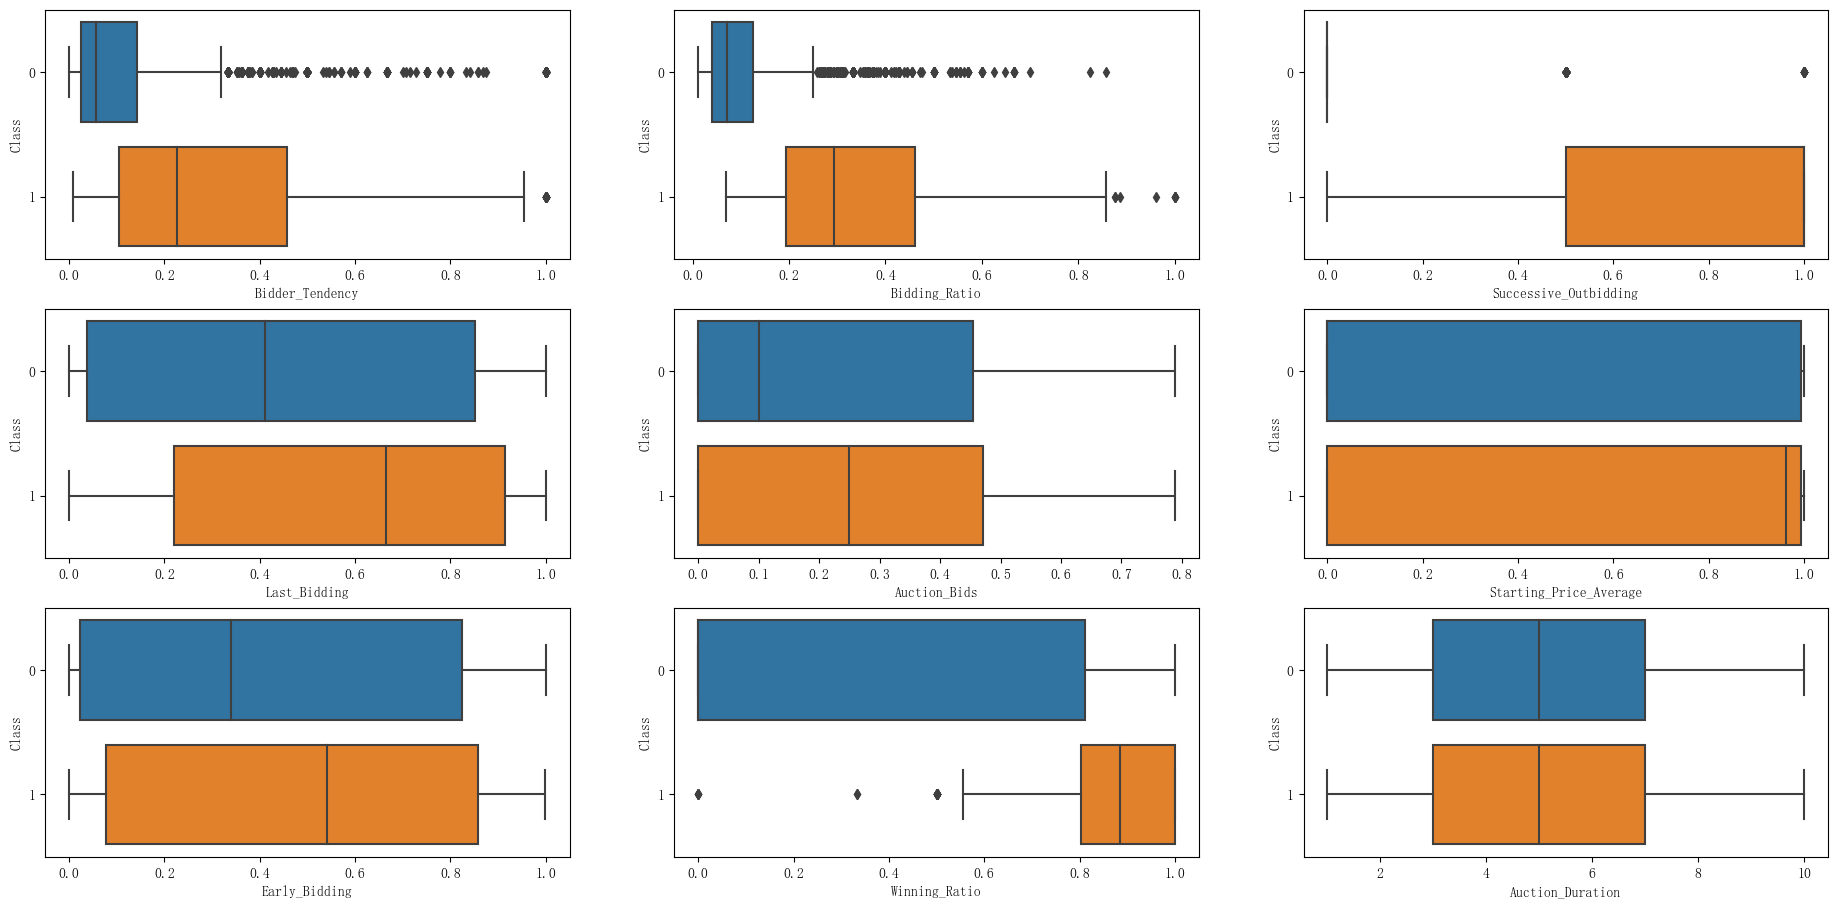

In [27]:
w = pd.read_csv("../data/Bidding.csv").iloc[:,3:]
# 设置字体为宋体
#plt.rcParams['font.sans-serif'] = 'SimSun'
plt.figure(figsize=(23,11))
for i,j in enumerate(w.columns[:-1]):
    plt.subplot(3,3,i+1)
    sns.boxplot(y="Class",x=j,data=w,dodge=True,orient='h')
plt.show

每个自变量与因变量之间的关系盒装图，从图中可以看出每个数量变量对目标变量的影响。Successive_Outbidding、Winning_Ratio、Bidding_Ratio造成了Class的巨大差距。Auction_Bids几乎与Class无影响。

**但是必须注意的是，这些自变量不是互相独立的，有些变量单独似乎对因变量影响不大，但在某种组合后可能就会有不可忽视的影响**

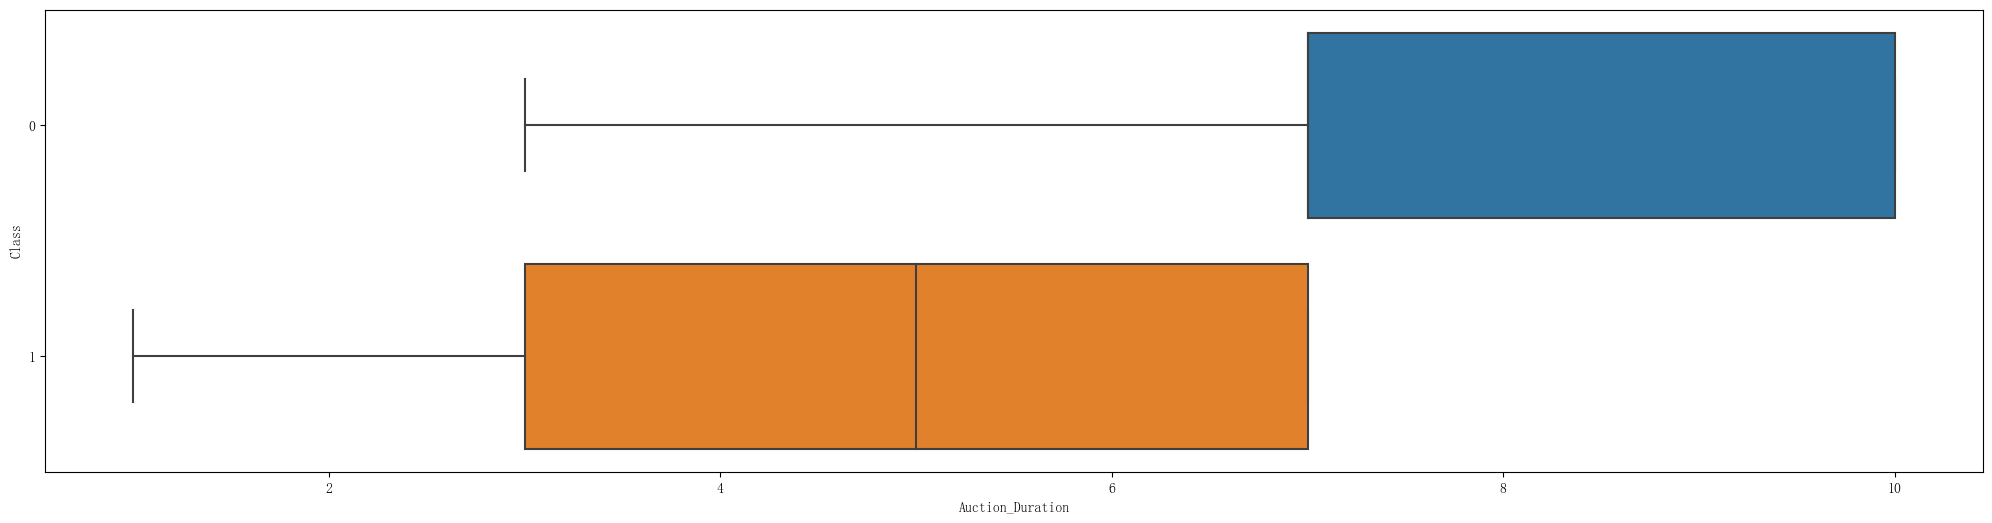

In [31]:
plt.figure(figsize=(25,6))
w1 = w[w['Successive_Outbidding']>0.75]
sns.boxplot(y="Class",x=j,data=w1,dodge=True,orient='h')
plt.show()

在任何数据分析中，简单的诸如散点图、或者其他形式的(多重盒装图)描述两个变量之间的图形无法描述更深层次的关系，往往具有误导作用。不幸的是，人类的感官及手段具有局限性，无法实现交高层次的可视化，因此，多数情况下必须使用其他方式来探索数据之间的关系。在多数情况系，自变量总体对于因变量预测的精确度是一个最重要的度量。

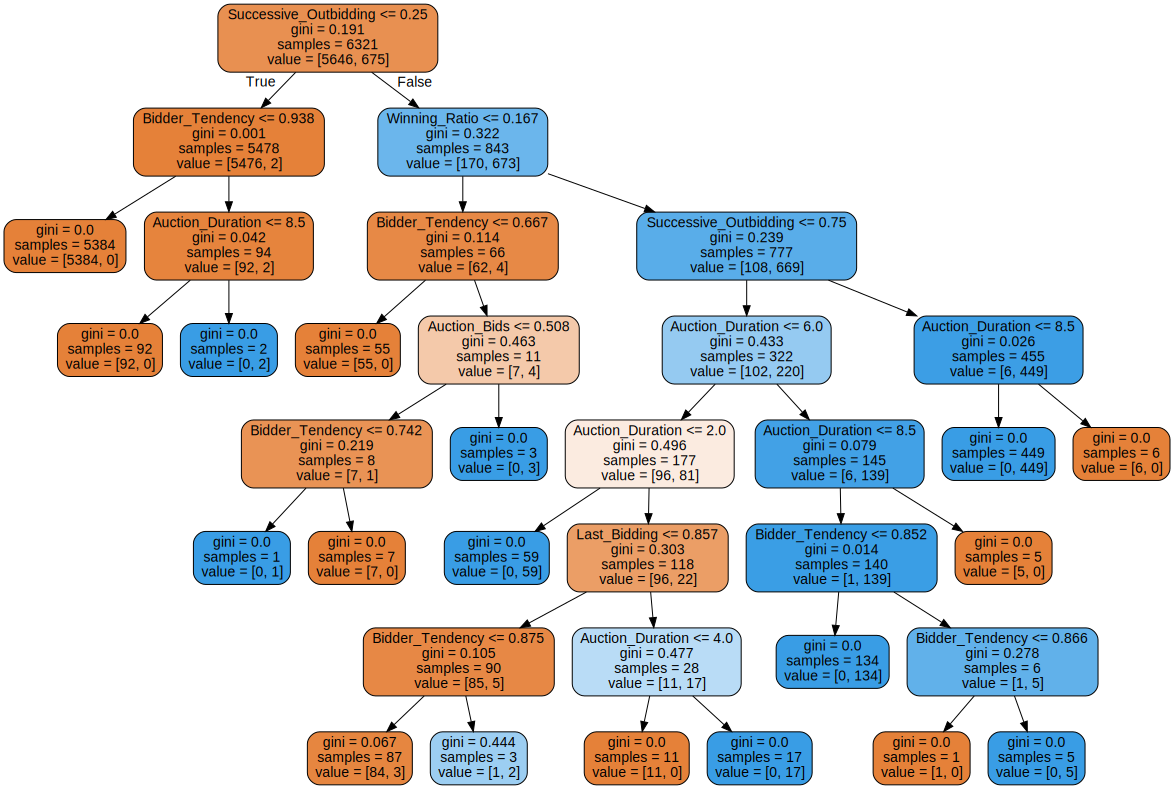

In [34]:
x = w.iloc[:,: -1]
y = w.iloc[:,-1].astype('category')
clf = DecisionTreeClassifier(max_depth=7)
clf = clf.fit(x,y)

dot_data = tree.export_graphviz(clf,out_file=None,feature_names=x.columns,rounded=True,filled=True)
graph = graphviz.Source(dot_data)
graph


In [47]:
names = ["Bagging","Random Forest","AdaBoost","Logit"]
classifiers = [
    BaggingClassifier(n_estimators=100,random_state=1010),
    RandomForestClassifier(n_estimators=500, random_state=0),
    AdaBoostClassifier(n_estimators=100, random_state=0),
    LogisticRegression(solver="liblinear")]
CLS = dict(zip(names,classifiers))
# 假设你有训练集X_train和目标变量y_train

for name, clf in CLS.items():
    scores = cross_val_score(clf, x, y, cv=5, scoring='accuracy')
    print(f"{name}: {scores.mean()}")



Bagging: 0.9977853104517937
Random Forest: 0.993988092259969
AdaBoost: 0.9941469455145844
Logit: 0.9753193325661679


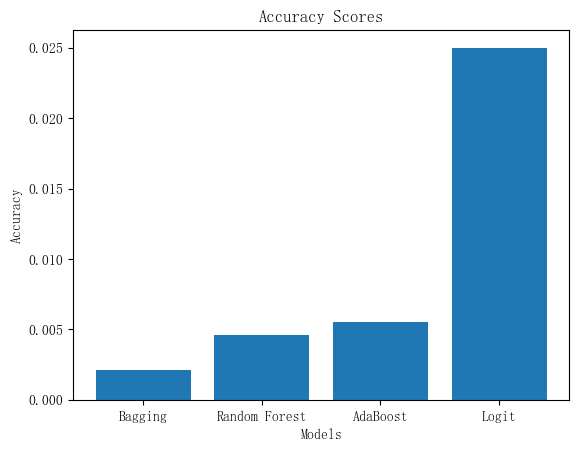

In [46]:
dic = {"Bagging": 0.0021,
       "Random Forest": 0.0046,
       "AdaBoost": 0.0055,
       "Logit": 0.025}
# 提取字典中的键和值
labels = dic.keys()
values = dic.values()
# 绘制直方图
plt.bar(labels, values)
# 添加标题和标签
plt.title("Accuracy Scores")
plt.xlabel("Models")
plt.ylabel("Accuracy")

# 显示图形
plt.show()
